# Tecnológico de Monterrey
## MR4010 Navegación autónoma

### Profesor titular: Dr. David Antonio-Torres
### Profesor tutor: Dr. Rafael Mendoza Crespo

## Equipo#15
#### Emmanuel Domínguez Bravo A01793683
#### Maximiliano Morones Gómez A01793815
#### Saúl Yovani Salgueiro Lindoro A01633510
#### Gerardo Quiroga Nájera A00967999

# DETECCION DE PEATONES CON HOG Y SVM

##### Se cargan las bibliotecas necesarias

##### En esta primera sección, cargamos diferente librerías las cuales son indispensables para cumplir diferentes propositos, algunos ejemplos de esto son la creación de figuras, el trazado de figuras, el trazado de imagenes, el análisis y manipulación de datos, creación de gráficos, manejo de imagenes y extracción y procesamiento de imagenes.

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog

# Se importan los dos datasets 
### https://docs.python.org/3/library/glob.html

##### En esta segunda sección se importan los datasets a utilizar, pero ademas se hace uso de la función/biblioteca glob, la cual se encarga de buscar archivos y directorios que coincidan con un determinado tipo de patron, así como también el manejo de archivos que se encuentran localizados dentro de un directorio en especifico, para realizar el manejo de operaciones en lotes.

In [3]:
import glob

#Para las imágenes de peatones utilizamos diversos conjuntos de datos: Kaggle, paperswithcode.com y GitHub/Pedestrian Detection.
peaton = glob.glob(r"peatones/si_peatones/**/*.*")  

#Para las imágenes sin peatones utilizamos el conjunto de datos sin vehículos de la práctica de HOG+SVM.
no_peaton = glob.glob(r"D:\Navegación Autónoma_Scripts\03_Machine_Learning\data_svm\non-vehicles\**\*.png") 

In [4]:
#len(vehicle)
len(peaton)

2241

In [5]:
#len(no_vehicle)
len(no_peaton)

3900

# Se muestra una imagen con personas (peatones)

##### En esta pequeña sección se lleva a cabo la lectura de una imagen, así como el proceso correspondiente a la estandarización del tamaño, con el objetivo de poder procesar cada una de las imagenes, de las cuales se hara uso. De tener imágenes con diferentes tamaños, tendríamos vectores con números distintos de características utilizando los mismos parámetros en el modelo HOG, haciendo imposible compararlos entre sí.  

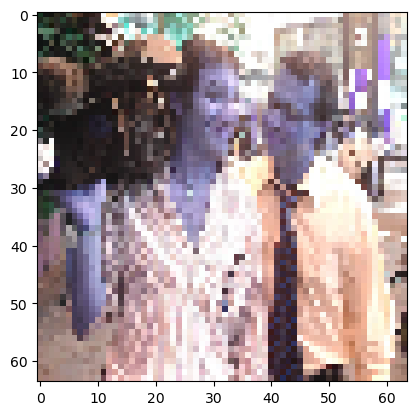

In [6]:
img = cv2.imread(peaton[17])
img_color_peaton = cv2.resize(img, (64,64)) #Estandarizamos el tamaño de todas las imágenes para poder procesarlas.
plt.imshow(img_color_peaton)

# Se obtiene la imagen en escala de grises

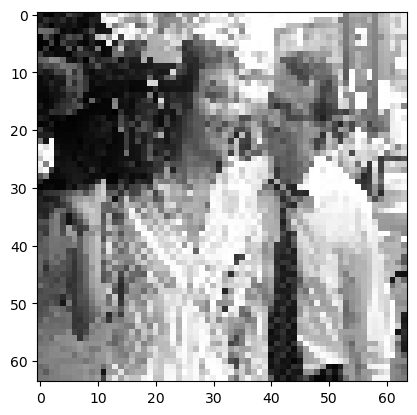

In [7]:
img_gray_peaton = cv2.cvtColor(img_color_peaton,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray_peaton,cmap="gray")

# Se calculan los gradientes en ambas direcciones con Sobel

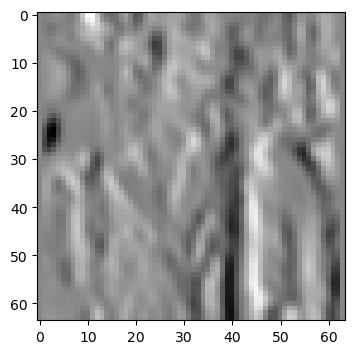

In [43]:
# Sobel en dirección X
x_sobel = cv2.Sobel(img_gray_peaton, cv2.CV_64F, 1, 0, ksize = 7)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.imshow(x_sobel,cmap='gray')

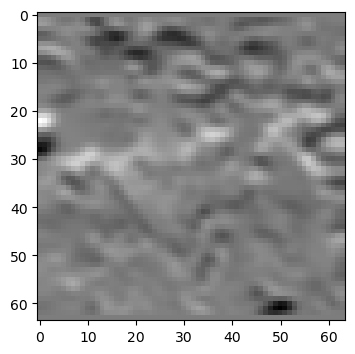

In [42]:
# Sobel en dirección Y
x_sobel = cv2.Sobel(img_gray_peaton, cv2.CV_64F, 0, 1, ksize = 7)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.imshow(x_sobel,cmap='gray')

In [45]:
#Calculamos las características del vector HOG en una imagen para determinar el mejor ajuste de los parámetros.
features,hog_img = hog(img_gray_peaton,
                       orientations = 10,
                       pixels_per_cell = (16,16),
                       cells_per_block = (2,2),
                       transform_sqrt = False,
                       visualize = True,
                       feature_vector = True)

In [46]:
features.shape # Mostramos el número de características por vector

(360,)

In [47]:
hog_img.shape # Desplegamos el tamaño de la imagen de gradientes generada

(64, 64)

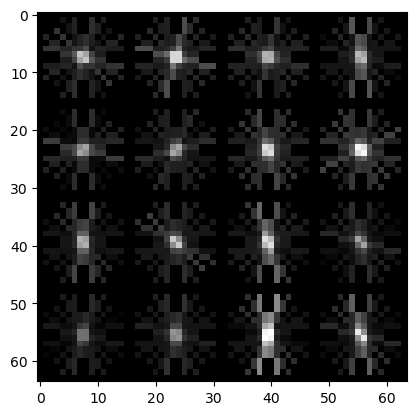

In [48]:
plt.imshow(hog_img,cmap = 'gray') # Mostramos la imagen

# Se extraen las features del HOG para ambos tipos de datos

##### El objetivo de esta sección, consiste en realizar un ciclo for por cada imagen e ir almacenando cada uno de los features del modelo HOG y así realizar el análisis de los datos y alimentar a la máquina conocida como soporte de vector o SVM. 

##### Para el ajuste de los parámetros, empezamos con una configuración de 8x8 pixeles por celda, pero nos arrojaba alrededor de 2,500 características por vector aún con un tamaño de imagen razonable de 64x64 pixeles, lo cual hacía muy lento el procesamiento de los datos, por lo que fuimos ajustando hasta llegar a un tamaño de 16x16 y 360 características por vector, similar al ejercicio de HOG/SVM. 

In [49]:
peaton_hog_accum = []

# extraemos las características de vector de cada imagen de peatones:

for i in peaton:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    img_res = cv2.resize(img_gray, (64,64))
    peaton_hog_feature, peaton_hog_img = hog(img_res,
                                               orientations = 10, #Escogemos 10 bins por histograma 
                                               pixels_per_cell = (16,16), #con 16 pixeles por celda tendríamos 64/16 = 4 x 4 = 16 celdas en total 
                                               cells_per_block = (2,2), # de acuerdo con PyImageSearch(2023), se recomienda usar bloques de tamaño 2x2 o 3x3
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    peaton_hog_accum.append(peaton_hog_feature)

In [50]:
X_peaton = np.vstack(peaton_hog_accum).astype(np.float64)
y_peaton = np.ones(len(X_peaton)) # Asignamos la clase 1 a las imágenes con peatones

In [51]:
X_peaton.shape # Mostramos 2241 vectores y 360 características por vector

(2241, 360)

In [52]:
y_peaton.shape 

(2241,)

In [16]:
no_peaton_hog_accum = []

for i in no_peaton:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    #Utilizamos los mismos parámetros que para los vectores de imágenes con peatones:
    
    no_peaton_hog_feature, no_peaton_hog_img = hog(img_gray,
                                               orientations = 10,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    no_peaton_hog_accum.append(no_peaton_hog_feature)

In [17]:
X_no_peaton = np.vstack(no_peaton_hog_accum).astype(np.float64)
y_no_peaton = np.zeros(len(X_no_peaton))  # Asignamos la clase 1 a las imágenes sin peatones

In [18]:
X_no_peaton.shape ## Mostramos 3900 vectores y 360 características por vector

(3900, 360)

In [19]:
y_no_peaton.shape

(3900,)

# Se combinan ambos tipos de datos para alimentar el SVM

In [20]:
X = np.vstack((X_peaton,X_no_peaton))
X.shape

(6141, 360)

In [21]:
y = np.hstack((y_peaton,y_no_peaton))
y.shape

(6141,)

# Se generan los datos de entrenamiento y de prueba

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [23]:
X_train.shape

(4298, 360)

In [24]:
X_test.shape

(1843, 360)

# Se importa el Clasificador y se entrena

##### Ademas de importar y entrenar al clasificador, se hace uso de este ya que es de gran utilidad, para llevar a cabo la división del conjunto de datos, la detección de peatones donde las caracteristicas pueden ser complejas y no lineales, como es el caso de la forma.
##### Sin pasar por alto que este modelo, es excelente para el manejo de caracteristicas de alta dimensión.

In [25]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)

SVC()

In [26]:
y_predict = svc_model.predict(X_test)

#### Se lleva a cabo la importación desde las métricas de Sckit Learn, del reporte de clasificación y la matriz de confusión, con el objetivo de poder realizar una impresión del reporte, enfocado especificamente en la variable de tipo Y y poder visualizar si los resultados son o no favorables.

<Axes: >

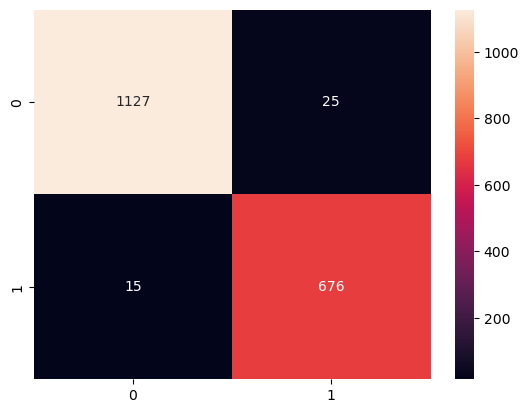

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot=True, fmt = "d")

#### Vemos que el modelo tiene errores mínimos, con 25 falsos positivos y 15 falsos negativos, de acuerdo a la configuración por omisión de sklearn mostrada abajo. En este caso sería más costoso el error de un falso negativo, donde el modelo predice que no hay peatón cuando la clase real es que sí lo hay, por lo que cualquier mejora tendría qué ser encaminada a reducir este error. El caso del falso positivo, no tendría más costo que tal vez una reducción en la velocidad innecesaria que sería percibida como incómoda para el usuario y repercutiría en la satisfacción del cliente. 

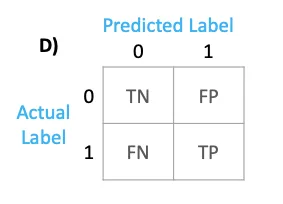

##### Imagen tomada de Samarth (2021).




In [28]:
# Revisamos los resultados con diferentes métricas
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1152
         1.0       0.96      0.98      0.97       691

    accuracy                           0.98      1843
   macro avg       0.98      0.98      0.98      1843
weighted avg       0.98      0.98      0.98      1843



# GridSearchCV

##### Se importa la librería de GridSearchCV, para poder dar inicio a la busqueda de los mejores parámetros, en base a una serie de valores y así poder obtener una nueva matríz de confusión y observar si los resultados obtenidos presentaron o no una mejora.

In [29]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [30]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.938 total time=   2.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.936 total time=   2.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.947 total time=   2.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.953 total time=   2.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.936 total time=   2.4s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.962 total time=   1.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.960 total time=   1.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.959 total time=   1.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.969 total time=   1.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.959 total time=   1.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.942 total time=   2.8s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

In [31]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [32]:
grid.best_estimator_

SVC(C=10, gamma=0.1)

In [33]:
grid_predictions = grid.predict(X_test)

<Axes: >

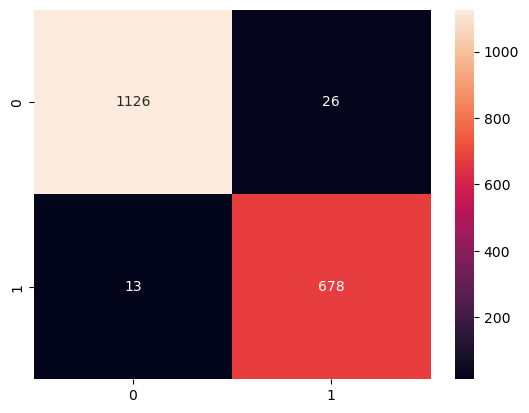

In [34]:
cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt = "d")

In [35]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1152
         1.0       0.96      0.98      0.97       691

    accuracy                           0.98      1843
   macro avg       0.98      0.98      0.98      1843
weighted avg       0.98      0.98      0.98      1843



#### Una vez analizados los resultados obtenidos, se observa una ligera mejora en los falsos negativos que ahora muestran 13 predicciones erróneas y un aumento en los falsos positivos, con 26 (como dijimos anteriormente, este costo es el menor). Aunque la mejora no es considerable respecto a la primer matriz de confusión, se sigue teniendo un desempeño bastante alto, aunque en el entorno automotriz la competitividad es alta y se desea reducir los errores al máximo, ya que de otro modo las vidas humanas son las que se ponen en riesgo.


**Referencias:**

PyImageSearch.(2023). _Histogram of Oriented Gradients (and car logo recognition)_. https://customers.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/

Samarth, A. (2021). _Understanding the Confusion Matrix from Scikit learn: A clear representation of output of confusion matrix_. https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79

--Fin de la actividad--